In [1]:
import sounddevice as sd
from scipy.io.wavfile import write
import sounddevice as sd
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftshift, ifft, fftfreq
import numpy as np
import simpleaudio as sa
import wave
from scipy.signal import chirp, correlate
import math, cmath

In [2]:
# Function to display something quickly
def plot_y(y):
    x = np.linspace(0, len(y), len(y))
    plt.plot(x, y)
    plt.show

In [46]:
fs = 44100  # 44100 samples per second
sd.default.samplerate = 44100  # Sample rate
sd.default.channels = 1


def record(filename, seconds):
    myrecording = sd.rec(int(seconds * sd.default.samplerate))
    print("recording")
    sd.wait()  # Wait until recording is finished
    print("writing")
    write(filename, fs, myrecording)  # Save as WAV file 
    print("done")
    return myrecording
def play(filename):
    # Extract data and sampling rate from file
    data, fs = sf.read(filename, dtype='float32')  
    sd.play(data, fs)
    print("playing")
    print(sd.default.device)
    print(data)
    status = sd.wait()  # Wait until file is done playing
    print("done")
def plot_y(y):
    x = np.linspace(0, len(y), len(y))
    '''
    fig = plt.figure()
    ax = fig.add_subplot(2, 1, 1)
    ax.set_yscale('log')
    '''
    plt.plot(x, y)
    plt.show
    
def play_np_BT(note):
    # Ensure that highest value is in 16-bit range
    audio = note * (2**15 - 1) / np.max(np.abs(note))

    # Convert to 16-bit data
    audio = audio.astype(np.int16)

    # Start playback
    play_obj = sa.play_buffer(audio, 1, 2, fs)

    # Wait for playback to finish before exiting
    play_obj.wait_done()
    print("done")
    
y = record("blah.wav", 5)


recording
writing
done


done


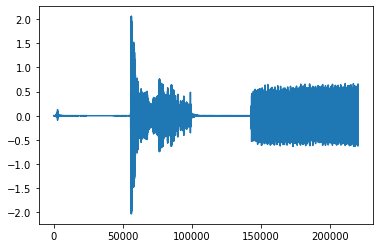

In [42]:
plot_y(y)
play_np_BT(y)

(88200,) (220500,)


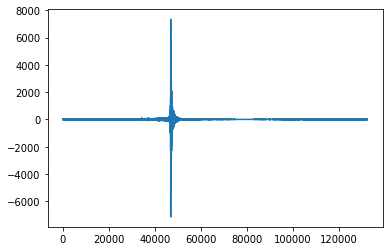

In [47]:
data = np.reshape(y, y.size)

frequency = 440  # Our played note will be 440 Hz
fs = 44100  # 44100 samples per second

sec = 2
t = np.linspace(0, sec, sec * fs)
h = chirp(t, f0=2000, f1=4000, t1=sec, method='linear')

scaled = np.int16(h/np.max(np.abs(h)) * 32767)
write('chirp.wav', 44100, scaled)

h_rev = h[::-1]

print(h_rev.shape, data.shape)

g = np.convolve(data, h_rev, 'valid')
x = np.correlate(data, h, 'valid')
plot_y(g)

132301 220500 88200
46865


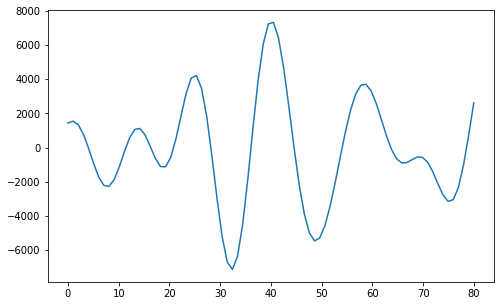

In [55]:
## print(len(g), len(y), len(h_rev))
dg = len(g)
dy = len(y)
dh = len(h_rev)

print(dg, dy, dh)

i_max = np.argmax(g)

rng = 40


k = g[i_max - rng:i_max + rng]

#plot_y(k)
print(i_max)

fig = plt.figure(figsize = (8,5))

x = np.linspace(0, len(k), len(k))
plt.plot(x, k)
plt.show
plt.savefig("Data_Files/smoothresponse.pdf")

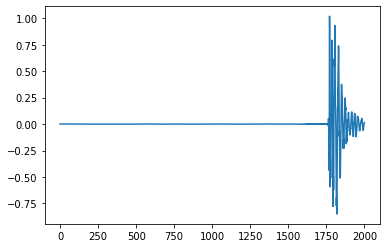

In [7]:
rng2 = 1000
cntr = int(i_max)# - dh/2)
plot_y(y[cntr - rng2:cntr  + rng2])

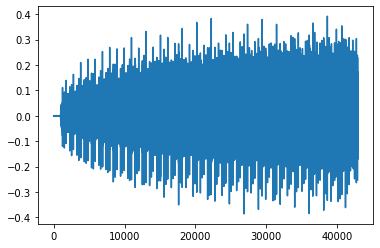

In [8]:
repeat = 20
dft = 2048
time_start_index = cntr + dh + 44100 + dft*0
time = y[time_start_index-1000:time_start_index+repeat*dft + 1000]

plot_y(time)

5 5
max  565.1709480950202 mean  126.02207051433459 i_max  658 real i_max  658.0


/Users/kaijunge/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


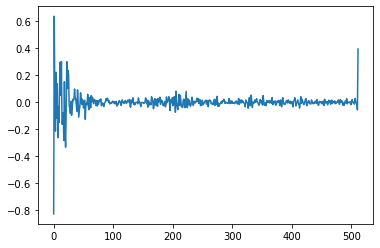

In [19]:
time_data = y[time_start_index:]
dft = 2048

samples = []
freq = []


timeshift = 676
for i in range(repeat):
    samples.append(time_data[dft*i:dft*(i+1)][timeshift:timeshift+1024])
    samples[i] = np.reshape(samples[i],np.zeros(1024).shape)
    freq.append(fft(samples[i]))
    

Phase = np.zeros(511)
for freq_response in freq:
    
    for i in range(1,int(len(freq_response)/2)):
        div = (freq_response[i]/F[0][i] )
        Phase[i-1] += cmath.phase(div)        
        
Phase = [x/repeat for x in Phase]

max_conv = []
for s in range(1000):
    P = []
    coeff = -0.01-s*0.001
    n = 0
    sign = coeff/abs(coeff)
    for i in range(1,511):
        val = math.pi * coeff * i - sign *2*math.pi*n

        if sign > 0:
            if val > math.pi:
                val = val - 2*math.pi
                n += 1
        else:
            if val < -1*math.pi:
                val = val + 2*math.pi
                n += 1   
                
        P.append(val)
        
    max_conv.append( max(correlate(P, Phase)))

max_conv = np.asarray(max_conv)
i_max = np.argmax(max_conv)
max_conv_mean = np.mean(max_conv)
max_conv_max = np.max(max_conv)

count_up = 0
count_down = 0
cutoff = 0.75
for i in range(100):
    if max_conv[i_max+i] > max_conv_max*cutoff:
        count_up +=1
    
    if max_conv[i_max-i] > max_conv_max*cutoff:
        count_down +=1

print(count_up, count_down)

real_imax = i_max + (count_up - count_down)/2


#plot_y(max_conv[600:700])
print("max ", max_conv_max, "mean ", max_conv_mean, "i_max ", i_max, "real i_max ", real_imax)


TF = np.zeros(511,dtype=complex)
TF_without_rotation = np.zeros(511,dtype=complex)
for freq_response in freq:
    
    for i in range(1,int(len(freq_response)/2)):
        div = (freq_response[i]/F[0][i] ) * cmath.rect(1, math.pi* (0.01+(real_imax)*0.001) * i)
        div2 = (freq_response[i]/F[0][i] )
        TF[i-1] += div 
        TF_without_rotation[i-1] += div2
        
TF = [x/repeat for x in TF]
TF_without_rotation = [x/repeat for x in TF_without_rotation]

impulse = ifft(TF)
plot_y(impulse)

In [20]:
sum_0 = 0
for freqres in freq:
    sum_0 += freqres[1]
    
sum_0 /= repeat
print(sum_0)
print(F[0][1])

TF_test = sum_0/F[0][1]
print(sum_0/F[0][1])


(-0.017559196427464487+0.004602701403200626j)
(-0.7071067811865475+0.7071067811865475j)
(0.01567082824002674+0.009161625492066738j)


In [21]:
time_start_index_content = time_start_index+repeat*dft
time_data_content = y[time_start_index_content:]

samples_content = []
freq_content = []

# get the FFT of the data
for i in range(repeat):
    samples_content.append(time_data_content[dft*i:dft*(i+1)][timeshift:timeshift+1024])
    samples_content[i] = np.reshape(samples_content[i],np.zeros(1024).shape)
    freq_content.append(fft(samples_content[i]))

    
TF_use = TF_without_rotation
response = np.zeros(511, dtype = complex)
for freq_response in freq_content:

    for i in range(1,int(len(freq_response)/2)):
        div = (freq_response[i]/ TF_use[i-1]) / cmath.rect(1, math.pi* (0.01+(real_imax)*0.001) * i)
        div2 = (freq_response[i]/TF_use[i-1] )
   
        response[i-1] += div2

response = np.asarray([x/repeat for x in response])

match_count = [0,0,0]
for i, val in enumerate(response):
    RE = "Plus"
    IM = "Plus"
    if val.real < 0:
        RE = "Minus"
        
    if val.imag < 0:
        IM = "Minus"
        
    val2 = F[1][i+1]
    RE2 = "Plus"
    IM2 = "Plus"
    if val2.real < 0:
        RE2 = "Minus"
        
    if val2.imag < 0:
        IM2 = "Minus"
    
    
    #print(RE, IM, "     ", RE2, IM2)
    if RE == RE2 and IM == IM2:
        print("Match!")
        match_count[0] += 1
        match_count[2] += 1
    else:
        print("no match....")
        match_count[1] += 1
        match_count[2] += 1

print("Percent successful = ", match_count[0]/match_count[2])

no match....
no match....
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
no match....
Ma

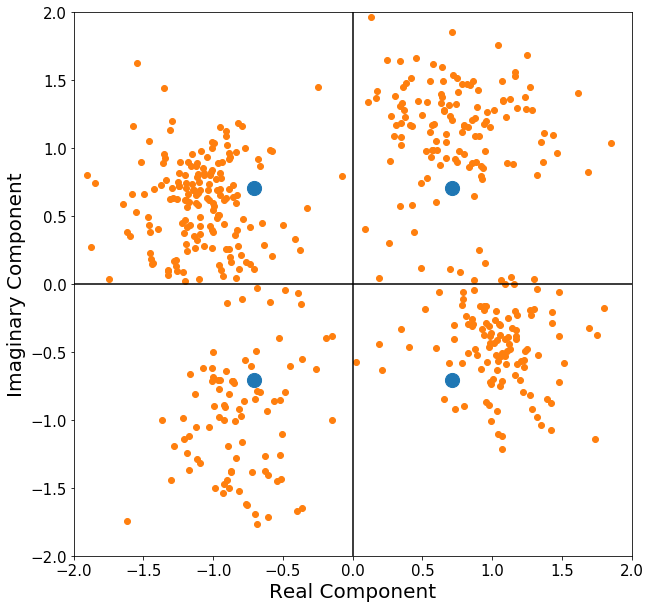

In [51]:
res = response#[:10]
fig = plt.figure(figsize =(10,10))
plt.scatter([0.71,0.71,-0.71,-0.71],[0.71,-0.71,0.71,-0.71], s = 200)
plt.plot([-20,20], [0,0], color = 'black')
plt.plot([0,0], [-20,20], color = 'black')
plt.xlim([-2,2])
plt.ylim([-2,2])

plt.xlabel("Real Component", fontsize=20)
plt.ylabel("Imaginary Component", fontsize=20)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.scatter(res.real, res.imag)
for val in res:
    pass #print(val)

plt.savefig('argand.pdf')

In [10]:
# Combining data into 

freq = np.array([0, 1+1j, 1-1j, 1-1j, -1-1j, 1-1j, -1-1j, 1-1j])
freq2 = freq[:0:-1].conjugate()
freq_combined = np.concatenate((freq, [0],freq2))

time = ifft(freq_combined, n=16).real

print(time)

[ 0.375       0.70952327 -0.0517767  -0.22067086 -0.375      -0.32422425
 -0.0517767   0.10596988 -0.625       0.24758351  0.3017767  -0.02932914
  0.125      -0.13288253  0.3017767  -0.35596988]


In [11]:
a = [1,2,3,4,5,6,7,8]
print(a[:0:-1])

[8, 7, 6, 5, 4, 3, 2]


In [12]:
test_str = "abc"
print("The original string is : " + str(test_str)) 
  
# using join() + ord() + format() 
# Converting String to binary 
res = ''.join(format(ord(i), 'b') for i in test_str) 
  
# printing result  
print("The string after binary conversion : " + str(res)) 

print(type(res))


import binascii

binary_int = int(res, 2)
print(binary_int)
byte_number = binary_int.bit_length() + 7 // 8

binary_array = binary_int.to_bytes(byte_number, "big")
ascii_text = binary_array.decode()

print(ascii_text)

The original string is : abc
The string after binary conversion : 110000111000101100011
<class 'str'>
1601891
                  qc


In [13]:
string = 'hopefully this works yay'
binary = bin(int.from_bytes(string.encode(), 'big'))[2:]

print(binary)

n = int(binary, 2)
out = n.to_bytes((n.bit_length() + 7) // 8, 'big').decode()

print(out)

11010000110111101110000011001010110011001110101011011000110110001111001001000000111010001101000011010010111001100100000011101110110111101110010011010110111001100100000011110010110000101111001
hopefully this works yay


In [14]:
def qpsk(binary, n_adjust = False, n=1024):
    assert len(binary)%2 == 0, "Binary string should have length multiple of 2"

    # if you want to pad the original binary string so it fits the n piont DFT
    if n_adjust:
        split_length = int(n/2 - 1)
        remainder = split_length - int(len(binary)/2)%split_length

        for i in range(remainder):
            binary += '00'
        
    
    qam = []
    for i in range(int(len(binary)/2)):
        real = 1/math.sqrt(2)
        imaginary = 1/math.sqrt(2)*1j
        
        index = i*2
        if binary[index] == '1':
            imaginary *= -1
        
        if binary[index+1] == '1':
            real *= -1
            
        qam.append(real + imaginary)
        
    return qam

'''
produces a time series that takes a binary sequence into a time domain signal
binary: the binary sequence as a string
qam: function that returns complex constellation values taking a binary signal as input
n: DFT length
k: cyclic prefix length 
'''
def time_series(binary, qam, n, k):
    assert n>=k, "k must be < n"
    
    symbol = qam(binary, n_adjust = True, n = n)
    
    #split the symbols into relevant chunks
    split_length = int(n/2 - 1)
    
    # split out into chunks of data that is passed into the ifft
    chunks = []
    for i in range(0, len(symbol), split_length):
        chunks.append(symbol[i:i+split_length])


    time_series = []
    long_series = None
    freq_series = []
    for i, chunk in enumerate(chunks):
        chunk = np.asarray(chunk)
        chunk2 = chunk[::-1].conjugate()
        chunk_combined = np.concatenate(([0],chunk, [0],chunk2))
        
        freq_series.append(chunk_combined)
        
        time_chunk = ifft(chunk_combined).real
        time_chunk = np.concatenate((time_chunk[-1*k:], time_chunk))
        
        single_msg = time_chunk*(2**15 - 1) / np.max(np.abs(time_chunk))
    
        time_series.append(single_msg)
        if i == 0:
            long_series = single_msg
            
        else:
            long_series = np.concatenate((long_series, single_msg))
        
    return time_series, long_series, freq_series

In [15]:
file = open("Data_Files/Homecoming.txt")
line = file.read().replace("\n", " ")
file.close()

#print(line)

binary = '0' + bin(int.from_bytes(line.encode(), 'big'))[2:]
print(len(binary))

28432


<class 'numpy.float64'>
(28, 2048)


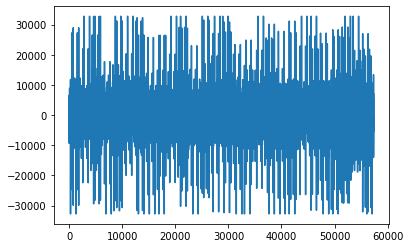

In [16]:
T,L,F = time_series(binary, qpsk, n=1024, k=1024)
plot_y(L)
print(type(t[0]))
print(np.asarray(T).shape)

In [17]:
for i in range(20):
    val = F[1][i]
    RE = "Plus"
    IM = "Plus"
    if val.real < 0:
        RE = "Minus"
        
    if val.imag < 0:
        IM = "Minus"
    
    print(RE, IM)

Plus Plus
Minus Minus
Minus Plus
Plus Minus
Plus Plus
Minus Plus
Minus Plus
Minus Minus
Plus Plus
Minus Minus
Minus Plus
Minus Minus
Minus Plus
Plus Plus
Minus Plus
Plus Minus
Minus Plus
Minus Plus
Plus Plus
Plus Minus


In [18]:
'''
audio = L

audio = audio.astype(np.int16)

# Start playback
play_obj = sa.play_buffer(audio, 1, 2, fs)

# Wait for playback to finish before exiting
play_obj.wait_done()'''

'\naudio = L\n\naudio = audio.astype(np.int16)\n\n# Start playback\nplay_obj = sa.play_buffer(audio, 1, 2, fs)\n\n# Wait for playback to finish before exiting\nplay_obj.wait_done()'

(44100,)
(88200,)
(2048,)


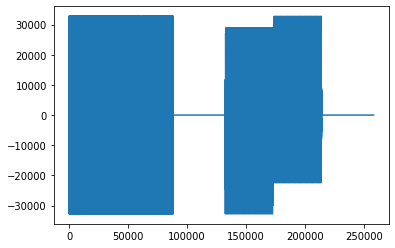

In [45]:
fs = 44100  # 44100 samples per second

sec = 2
t = np.linspace(0, sec, sec * fs)
h = chirp(t, f0=2000, f1=4000, t1=sec, method='linear')

scaled = np.int16(h/np.max(np.abs(h)) * 32767)

one_sec_zeros = np.zeros(fs)

print(one_sec_zeros.shape)
print(scaled.shape)
print(T[0].shape)


for i in range(20):
    if i ==0:
        T_0_many_times = T[0]
    else:
        T_0_many_times = np.concatenate((T_0_many_times, T[0]))
        

for i in range(20):
    if i ==0:
        T_1_many_times = T[1]
    else:
        T_1_many_times = np.concatenate((T_1_many_times, T[1]))
        
        
out = np.concatenate((scaled,one_sec_zeros,T_0_many_times,T_1_many_times,one_sec_zeros))
write('chirp_signal_3.wav', 44100, out)


note = out
# Ensure that highest value is in 16-bit range
audio = note * (2**15 - 1) / np.max(np.abs(note))

plot_y(audio)
# Convert to 16-bit data
audio = audio.astype(np.int16)

# Start playback
play_obj = sa.play_buffer(audio, 1, 2, fs)

# Wait for playback to finish before exiting
play_obj.wait_done()